In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.max_columns", None)

In [4]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

X = np.array(data["data"])
y = np.array(data["target"])

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss

sigmoid = lambda z: 1 / (1+ np.exp(-z))


tree1 = DecisionTreeRegressor(max_depth=2)
tree1.fit(X, y)
y2 = y - tree1.predict(X)


tree2 = DecisionTreeRegressor(max_depth=2)
tree2.fit(X, sigmoid(y2))

y3 = y2 - tree2.predict(X)

tree3 = DecisionTreeRegressor(max_depth=2)
tree3.fit(X, sigmoid(y3))

y_pred = sum(tree.predict(X) for tree in (tree1, tree2, tree3))

print(f"loss: {log_loss(y, sigmoid(y_pred))}")



from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1e-3)
xgb.fit(X, y)

print(f"Loss: {log_loss(y, xgb.predict_proba(X))}")


loss: 0.5771750198838852
Loss: 0.657821505831818


In [21]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss

sigmoid = lambda z: 1 / (1 + np.exp(-z))

# Initialize F0 with log-odds
p = np.clip(y.mean(), 1e-6, 1-1e-6)
F = np.log(p / (1 - p))  # scalar
F_m = np.full_like(y, F, dtype=float)

learning_rate = 1e-2
n_estimators = 3
trees = []

for m in range(n_estimators):
    # Compute current probabilities
    p_m = sigmoid(F_m)
    
    # Compute pseudo-residuals (negative gradient of log loss)
    r_m = y - p_m

    # Fit regression tree on residuals
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X, r_m)
    trees.append(tree)
    
    # Update model (logit space)
    F_m += learning_rate * tree.predict(X)

# Final prediction
y_pred_proba = sigmoid(F_m)
print("Manual log loss:", log_loss(y, y_pred_proba))

Manual log loss: 0.6545022652749545


In [56]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

sigmoid = lambda z: 1 / (1 + np.exp(-z))

p = np.clip(y.mean(), 1e-6, 1-1e-6)
F = np.log(p / (1 - p))  # scalar
F_m = np.full_like(y, F, dtype=float)

lr = 1e-2
n_trees = 1000
max_depth = 2
trees = []

losses = []

for i in range(n_trees):
    p_m = sigmoid(F_m)

    residuals = y - p_m

    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(X, residuals)
    trees.append(tree)

    F_m += lr * tree.predict(X)
    loss = log_loss(y, sigmoid(F_m))
    losses.append(loss)
    if (i+1) % 100 == 0:
        print(f'iter: {i+1} loss={loss}')


y_proba = sigmoid(F_m)
print(f'loss: {log_loss(y, y_proba)}')

iter: 100 loss=0.5036774547236719
iter: 200 loss=0.40296331236920163
iter: 300 loss=0.3360609262387944
iter: 400 loss=0.2892399016028092
iter: 500 loss=0.2549124936354362
iter: 600 loss=0.22874431636098413
iter: 700 loss=0.2080247705144022
iter: 800 loss=0.19126411563278406
iter: 900 loss=0.17719755080379343
iter: 1000 loss=0.16533683066378926
loss: 0.16533683066378926


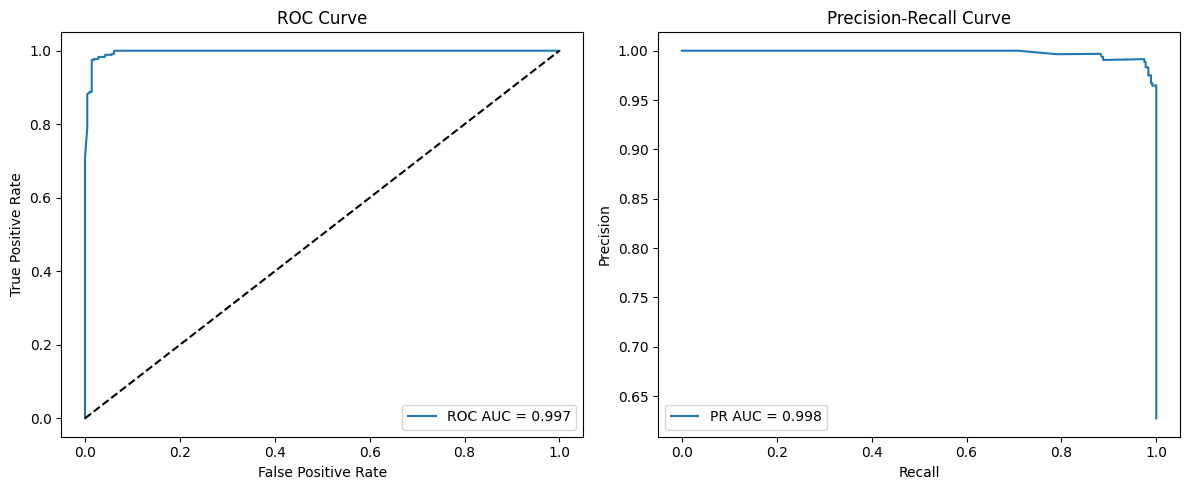

In [57]:
from sklearn.metrics import auc 

fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

precision, recall, _ = precision_recall_curve(y, y_proba)
pr_auc = auc(recall, precision)

# --- Plot ---
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

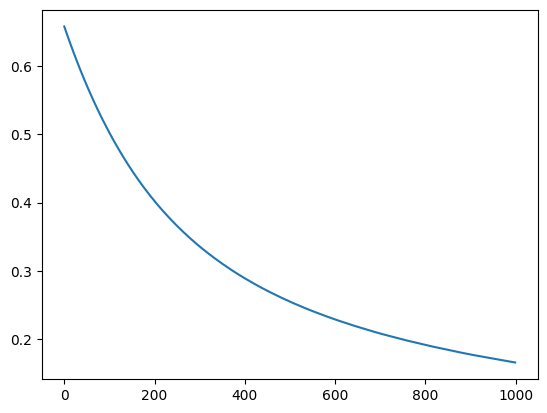

In [58]:
plt.plot(losses)